In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import os 
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [2]:

# Squeeze-and-Excitation (SE) Block for Attention Mechanism
from tensorflow.keras.layers import GlobalAveragePooling2D, Reshape, Dense, Multiply

def squeeze_excite_block(input_tensor, ratio=16):
    """
    Implements the Squeeze-and-Excitation (SE) Block.
    Args:
        input_tensor: Input feature map
        ratio: Reduction ratio for the fully connected layers
    Returns:
        Output tensor with attention applied
    """
    filters = input_tensor.shape[-1]  # Get the number of channels
    se = GlobalAveragePooling2D()(input_tensor)  # Global Average Pooling
    se = Reshape((1, 1, filters))(se)
    se = Dense(filters // ratio, activation='relu', use_bias=False)(se)  # Squeeze
    se = Dense(filters, activation='sigmoid', use_bias=False)(se)  # Excite
    return Multiply()([input_tensor, se])  # Apply attention

In [3]:

# Build CNN model with SE Attention Mechanism
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# Define input shape
input_shape = (256, 256, 3)  # Ensure this matches your dataset
inputs = Input(shape=input_shape)

# First Convolutional Block
x = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
x = squeeze_excite_block(x)  # Apply SE Block
x = MaxPooling2D(pool_size=(2, 2))(x)

# Second Convolutional Block
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = squeeze_excite_block(x)  # Apply SE Block
x = MaxPooling2D(pool_size=(2, 2))(x)

# Third Convolutional Block
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = squeeze_excite_block(x)  # Apply SE Block
x = MaxPooling2D(pool_size=(2, 2))(x)

# Flatten and Fully Connected Layers
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
outputs = Dense(4, activation='softmax')(x)  # Change number of classes accordingly

# Create new model
se_cnn_model = Model(inputs=inputs, outputs=outputs)

# Compile model
se_cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print summary
se_cnn_model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │        896 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 32)        │          0 │ conv2d[0][0]      │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 1, 1, 32)  │          0 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 1, 1, 2)   │         64 │ reshape[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 1, 1, 32)  │         64 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply (Multiply) │ (None, 256, 256,  │          0 │ conv2d[0][0],     │
│                     │ 32)               │            │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 128,  │          0 │ multiply[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 128, 128,  │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 64)        │          0 │ conv2d_1[0][0]    │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_1 (Reshape) │ (None, 1, 1, 64)  │          0 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 1, 1, 4)   │        256 │ reshape_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 1, 1, 64)  │        256 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_1          │ (None, 128, 128,  │          0 │ conv2d_1[0][0],   │
│ (Multiply)          │ 64)               │            │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 64, 64,    │          0 │ multiply_1[0][0]  │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 64, 64,    │     73,856 │ max_pooling2d_1[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 128)       │          0 │ conv2d_2[0][0]    │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_2 (Reshape) │ (None, 1, 1, 128) │          0 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 1, 1, 8)   │      1,024 │ reshape_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 67,207,364 (256.38 MB)

 Trainable params: 67,207,364 (256.38 MB)

 Non-trainable params: 0 (0.00 B)

In [4]:
# Set the path to the dataset
dataset_path = r'D:\IIT\Subjects\(4605)IRP\Devlo\Augmented_DataSet'

In [5]:
# Define image dimensions and other constants
img_height, img_width = 256, 256  # Image resolution
batch_size = 32
num_classes = 4  # 4 classes: Healthy, Live Wood, Pink Wax, Stem Canker

In [6]:
# Data Augmentation and Preprocessing
train_datagen = ImageDataGenerator(
    rescale=1./255,  # Normalize pixel values
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2  # Split 80% training, 20% validation
)

In [7]:
# Load training data
train_generator = train_datagen.flow_from_directory(
    dataset_path,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'  # Training subset
)

Found 7656 images belonging to 4 classes.


In [8]:
# Load validation data
validation_generator = train_datagen.flow_from_directory(
    dataset_path,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'  # Validation subset
)

Found 1914 images belonging to 4 classes.


In [9]:
# Build CNN model
model = Sequential()

In [10]:
# Convolutional layers
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(img_height, img_width, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

c:\Users\ridmi\.conda\envs\TenserFlow\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [11]:
# Flatten and Fully Connected layers
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))  # Output layer with 4 classes

In [12]:
# Compile the model
model.compile(optimizer=Adam(),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [13]:
# Model summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 254, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 60, 60, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 30, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 115200)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 128)            │    14,745,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,839,492 (56.61 MB)

 Trainable params: 14,839,492 (56.61 MB)

 Non-trainable params: 0 (0.00 B)

In [14]:
# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    epochs=30  # Adjust the number of epochs as needed
)

c:\Users\ridmi\.conda\envs\TenserFlow\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 790ms/step - accuracy: 0.3486 - loss: 1.4105

c:\Users\ridmi\.conda\envs\TenserFlow\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


239/239 ━━━━━━━━━━━━━━━━━━━━ 215s 895ms/step - accuracy: 0.3490 - loss: 1.4096 - val_accuracy: 0.5048 - val_loss: 1.0587
Epoch 2/30
  1/239 ━━━━━━━━━━━━━━━━━━━━ 2:31 637ms/step - accuracy: 0.5938 - loss: 1.0854

c:\Users\ridmi\.conda\envs\TenserFlow\lib\site-packages\keras\src\trainers\epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


239/239 ━━━━━━━━━━━━━━━━━━━━ 25s 101ms/step - accuracy: 0.5938 - loss: 1.0854 - val_accuracy: 0.4592 - val_loss: 1.0751
Epoch 3/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 215s 901ms/step - accuracy: 0.5453 - loss: 1.0551 - val_accuracy: 0.5842 - val_loss: 0.9583
Epoch 4/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 25s 102ms/step - accuracy: 0.4688 - loss: 1.0652 - val_accuracy: 0.5810 - val_loss: 0.9572
Epoch 5/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 215s 901ms/step - accuracy: 0.5996 - loss: 0.9714 - val_accuracy: 0.5916 - val_loss: 0.9052
Epoch 6/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 25s 104ms/step - accuracy: 0.6875 - loss: 0.6604 - val_accuracy: 0.5784 - val_loss: 0.9056
Epoch 7/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 218s 913ms/step - accuracy: 0.6204 - loss: 0.9065 - val_accuracy: 0.5900 - val_loss: 0.9422
Epoch 8/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 26s 105ms/step - accuracy: 0.5625 - loss: 1.0823 - val_accuracy: 0.5922 - val_loss: 0.9138
Epoch 9/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 289s 1s/step - accuracy: 0.6543 - loss: 0.8515 - va

In [15]:
# Save the model
model.save('D:\IIT\Subjects\(4605)IRP\Devlo\models\CNN_model_Attention.h5')

In [16]:
# Evaluate the model
score = model.evaluate(validation_generator)
print(f"Validation Loss: {score[0]}")
print(f"Validation Accuracy: {score[1]}")

60/60 ━━━━━━━━━━━━━━━━━━━━ 30s 502ms/step - accuracy: 0.6350 - loss: 0.8644
Validation Loss: 0.8449883460998535
Validation Accuracy: 0.6462904810905457


Found 958 files belonging to 4 classes.
30/30 ━━━━━━━━━━━━━━━━━━━━ 6s 179ms/step


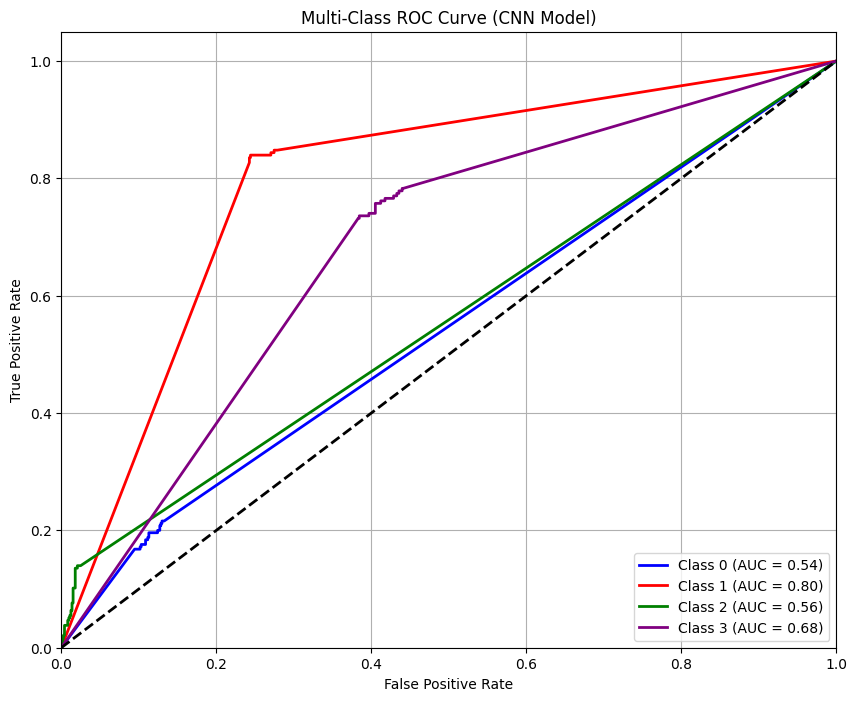

In [1]:
from tensorflow.keras.models import load_model
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

# Load your model
model = load_model(r"D:\IIT\Subjects\(4605)IRP\Devlo\models\CNN_model_Attention.h5")  # Correct model path

# Load Test Dataset with correct image size (256x256)
TEST_PATH = r"D:\IIT\Subjects\(4605)IRP\Devlo\Augmented_DataSet_Split\test"

test_ds = tf.keras.utils.image_dataset_from_directory(
    TEST_PATH,
    shuffle=False,
    batch_size=32,
    image_size=(256, 256)   # <<< VERY IMPORTANT: Match model's input size!!
)

# Now predict normally (no flattening)
y_pred = model.predict(test_ds)

# Get true labels
y_true = np.concatenate([y.numpy() for x, y in test_ds], axis=0)

# Binarize true labels
y_true_bin = label_binarize(y_true, classes=range(y_pred.shape[1]))

# Calculate ROC and AUC
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = y_pred.shape[1]

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC Curve
plt.figure(figsize=(10, 8))
colors = ['blue', 'red', 'green', 'purple', 'orange']
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], color=colors[i % len(colors)],
             lw=2, label='Class {0} (AUC = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-Class ROC Curve (CNN Model)')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()
